In [105]:
from qiskit import QuantumCircuit, execute, Aer
import qiskit.providers.aer.noise as noise
from random import uniform as randUniform
from math import pi
from qiskit.visualization import plot_histogram
from matplotlib import style
import matplotlib.pyplot as plt
%matplotlib inline


In [106]:

from qiskit.providers.aer.noise.errors import depolarizing_error


## Count functions

#### Getting the counts for by using qasm simulator. The error model used is by depolarizing aer.noise and the probabilities are chosen randomly.

In [107]:
def get_counts(params,shots):
    prob_1 = 0.001  # For Rx and Ry
    prob_2 = 0.01  # For CX

    # Depolarizing quantum errors
    error_1 = depolarizing_error(prob_1, 1)
    error_2 = depolarizing_error(prob_2, 2)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates

   # Two qubits and two classical bits
    circ = QuantumCircuit(2, 2)

    circ.ry(params[0], 0)
    circ.rx(params[1], 1)
    circ.cx(0, 1)
    circ.measure([0, 1], [0, 1])

    # Perform a noisy simulation and get the counts
    result = execute(circ, Aer.get_backend('qasm_simulator'),
                     basis_gates=basis_gates,
                     noise_model=noise_model, shots=shots).result()
    counts = result.get_counts()
    return counts

## Loss Function

In [108]:
def get_loss(counts):
    try:
        xx = counts['00']
    except KeyError:
        xx = 0
    try:
        xy = counts['01']
    except KeyError:
        xy = 0
    try:
        yx = counts['10']
    except KeyError:
        yx = 0
    try:
        yy = counts['11']
    except KeyError:
        yy = 0
    total = xx+xy+yx+yy
    # We would ideally want the costs at '00' and '11' to be as close to 0 as possible
    # and counts at '01' and '10' to be as close to total/2
    loss = [abs(xx-0),abs(xy-total/2),abs(yx-total/2),abs(yy-0)]
    return loss

## Stopping criteria

In [109]:
def stop(loss, error, shots):
    for l in loss:
        if l> error*shots:
            return False
    return True

## Gradient 

In [110]:
def get_gradient(counts):
    try:
        xx = counts['00']
    except KeyError:
        xx = 0
    try:
        xy = counts['01']
    except KeyError:
        xy = 0
    try:
        yx = counts['10']
    except KeyError:
        yx = 0
    try:
        yy = counts['11']
    except KeyError:
        yy = 0
    total = xx+xy+yx+yy
    grad_ry = ((xy+yy) - (xx+yx))/total
    grad_rx = pi*(xx+yy)/total
    return [grad_ry, grad_rx]

## Main loop

In [111]:
def start(shots=1000, error= 0.01, lr=1,printing=True):
    params = [randUniform(0, 2 * pi), randUniform(0, 2 * pi)]
    descending = True
    counts = []
#     loss = []
    steps = 0
    while descending:
        counts = get_counts(params, shots)
        loss = get_loss(counts)

        if stop(loss, shots, error):
            descending = False
            break

        gradient = get_gradient(counts)
        for i in range(len(params)):
            params[i] -= lr * gradient[i]
            while params[i] < 0:
                params[i] += 2 * pi
            params[i] = params[i] % (2 * pi)
        if(printing):
            print("Steps No: "+str(steps))
            print("Loss: "+str(loss))
            print("Parameters: "+str(params))
            print("Counts: "+str(counts))
            print("\n\n")
        steps += 1
    if(printing):
        print("FINAL")
        print("Steps Taken: "+str(steps))
        print("Loss: "+str(loss))
        print("Final parameters: "+str(params))
        print("Counts: "+str(counts))
    return counts

In [112]:
counts = start()

Steps No: 0
Loss: [704, 483.0, 260.0, 39]
Parameters: [1.3232644561395297, 5.047379198319719]
Counts: {'01': 17, '00': 704, '10': 240, '11': 39}



Steps No: 1
Loss: [414, 379.0, 290.0, 255]
Parameters: [1.5712644561395297, 2.9456537130681477]
Counts: {'01': 121, '00': 414, '10': 210, '11': 255}



Steps No: 2
Loss: [7, 3.0, 13.0, 9]
Parameters: [1.5592644561395297, 2.895388230610711]
Counts: {'01': 497, '00': 7, '10': 487, '11': 9}



Steps No: 3
Loss: [8, 13.0, 4.0, 9]
Parameters: [1.5672644561395297, 2.8419811554996848]
Counts: {'01': 487, '00': 8, '10': 496, '11': 9}



Steps No: 4
Loss: [8, 2.0, 27.0, 21]
Parameters: [1.5292644561395297, 2.7508749685455807]
Counts: {'01': 498, '00': 8, '10': 473, '11': 21}



Steps No: 5
Loss: [26, 57.0, 14.0, 17]
Parameters: [1.6092644561395297, 2.6157864844412195]
Counts: {'01': 443, '00': 26, '10': 514, '11': 17}



Steps No: 6
Loss: [25, 11.0, 62.0, 48]
Parameters: [1.5352644561395297, 2.3864502207291647]
Counts: {'01': 489, '00': 25, '10': 43

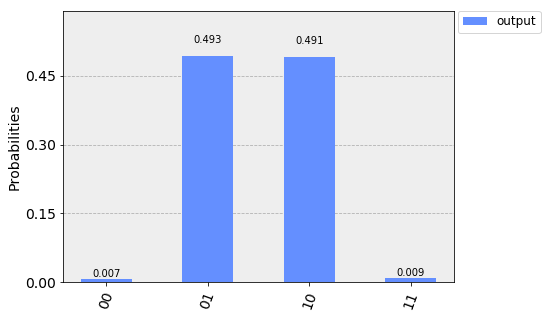

In [113]:
plot_histogram([counts], legend=['output'])

## Compare results for 1, 10, 100, 1000

### For 1 shot, convergence only when allowed error is >=0.5

FINAL
Steps Taken: 0
Loss: [0, 0.5, 0.5, 0]
Final parameters: [4.339704005719533, 1.119962707172297]
Counts: {'01': 1}
Counts: {'01': 1}


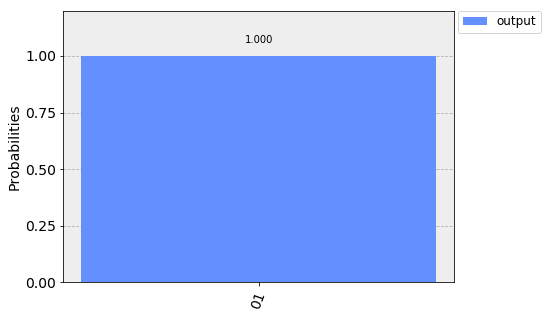

In [114]:
counts=start(shots=1,error=0.5,printing=True)
print("Counts: "+str(counts))
plot_histogram([counts], legend=['output'])

Counts: {'01': 5, '10': 5}


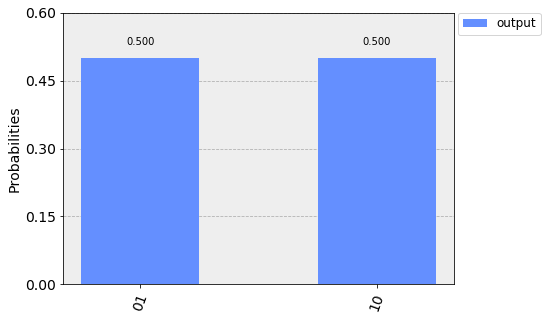

In [115]:
counts=start(shots=10,printing=False)
print("Counts: "+str(counts))
plot_histogram([counts], legend=['output'])


Counts: {'01': 50, '10': 50}


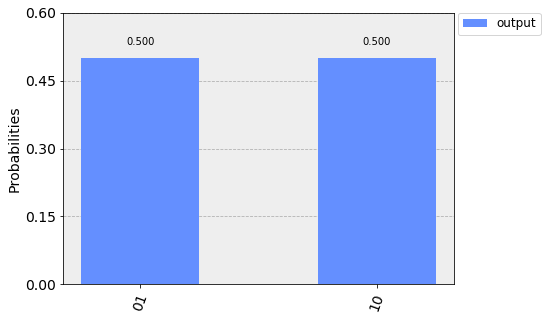

In [116]:
counts=start(shots=100,printing=False)
print("Counts: "+str(counts))
plot_histogram([counts], legend=['output'])

Counts: {'01': 503, '00': 2, '10': 493, '11': 2}


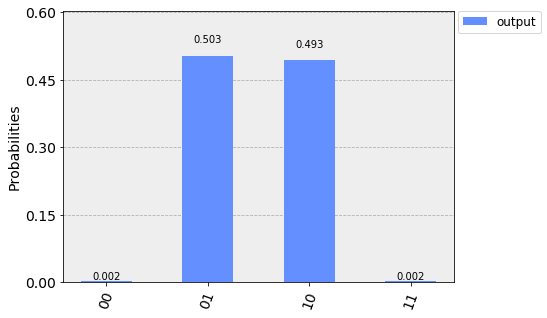

In [117]:
counts=start(shots=1000,printing=False)
print("Counts: "+str(counts))
plot_histogram([counts], legend=['output'])